In [1]:
import os, glob, platform
import numpy as np
import numpy.matlib
import pickle
import pandas as pd
import pathlib
import matplotlib
import matplotlib.pyplot as plt
import mne
mne.__version__
from mne.viz import plot_alignment, snapshot_brain_montage
import shutil
from mne.datasets import eegbci
from sklearn.model_selection import train_test_split

# from mne_bids import write_raw_bids, BIDSPath, print_dir_tree, make_dataset_description
# from mne_bids.stats import count_events
import sys


In [2]:
''' VARIABLES '''

dataset = 'eeg'

amount_of_subjects = 1 # Change the range so the process is faster

numC = 8

angles = [i * 180./numC for i in range(numC)]

x_labels = np.array(angles)

resample = False # speeds up the procees but showing worse results overall
resample_frequency = 20 # in Hz, original freq is 500Hz

In [3]:
from toolbox.methods import read_data
all_epochs, all_rawdata = read_data (task = 'main', resample=resample, amount_of_subjects=amount_of_subjects, resample_frequency=resample_frequency)

In [4]:
print(len(all_rawdata))
all_rawdata[0]['metadata'].columns

1


Index(['index', 'subj', 'nblock', 'ntrial', 'nrep', 'trial_type', 'cond-1',
       'cond', 'rDV', 'DV', 'resp', 'deci-2', 'deci-1', 'deci', 'corr-1',
       'r_map', 'correct', 'confi', 'RT', 'd1', 'conf_lvl', 'correct-1', 'd2',
       'd3', 'd4', 'd5', 'd6', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'confi-1',
       'conf_lvl-1'],
      dtype='object')

In [5]:
def diagonality(x):
    if x >= 0 and x <= 22.5:
        return 0
    elif x > 22.5 and x <= 67.5:
        return 1
    elif x > 67.5 and x <= 112.5:
        return 0
    elif x > 112.5 and x <= 157.5:
        return 1
    elif x > 157.5 and x <= 180:
        return 0

In [6]:
all_rawdata[0]['metadata'][['o1', 'o2', 'o3', 'o4', 'o5', 'o6']] *= 180 / np.pi
all_rawdata[0]['metadata']['o1'] = all_rawdata[0]['metadata']['o1'].apply(diagonality)

In [7]:
all_rawdata[0]['metadata']['o1']

883     1
896     1
909     1
922     0
935     0
       ..
4240    0
4253    0
4266    0
4279    1
4305    1
Name: o1, Length: 250, dtype: int64

In [92]:
'''7min for all subjects'''
use_timepoint = False
reshape = False
timepoint = 10
X = all_rawdata[0]['epoch_dat']
print(X.shape)
# X = X.reshape(X.shape[0],-1)
y = all_rawdata[0]['metadata']['deci']
y = np.array(y)
print(y.shape)

for i in range(1, amount_of_subjects):

    X_temp = all_rawdata[i]['epoch_dat']
    # X_temp = X_temp.reshape((X_temp.shape[0]*X_temp.shape[1], X_temp.shape[2]))
    # shapes[i+1] = shapes[i] + X_temp.shape[0]
    y_temp = all_rawdata[i]['metadata']['deci']
    # y_temp = np.tile(y_temp, numC)
    # X = np.vstack((X, X_temp))
    X = np.concatenate((X, X_temp))
    y = np.concatenate((y, y_temp))

print(X.shape, y.shape)
if use_timepoint: 
    X = X[:,:,timepoint]
else:
    if reshape:
        X = X.reshape(X.shape[0], -1)
print(X.shape, y.shape)
X = np.einsum('ijk->ikj',X)
X_eye = X[:,:,25]
X = np.delete(X, 25, axis=2)
print(X.shape, y.shape)


(250, 32, 2876)
(250,)
(250, 32, 2876) (250,)
(250, 32, 2876) (250,)
(250, 2876, 31) (250,)


In [100]:
from sklearn.svm import SVC
# from pyrcn.echo_state_network import ESNClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from catboost import CatBoostClassifier
# from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.svm import SVC

def train_3(X, y, verbose=False, display_roc=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    minority = np.unique(y_train,return_counts=True)[1][0]
    mayority = np.unique(y_train,return_counts=True)[1][1]
    # print(mayority/minority)
    class_weight = {
        0: 1.0,  
        1: mayority/minority
    }
    sample_weights = np.array([class_weight[label] for label in y_train])
    
    clf = CatBoostClassifier(task_type = 'GPU')
    clf = RandomForestClassifier() 
    # clf = SVC() # Faster than Random Forest
    clf.fit(X_train, y_train,
            sample_weight=sample_weights
            )

    y_pred = clf.predict(X_test)    
    if verbose:
        print(classification_report(y_test, y_pred))
        print(np.unique(y_test, return_counts=True))
        print(np.unique(y_pred, return_counts=True))
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    features = clf.feature_importances_
    if display_roc:
        # I think this is not working
        from sklearn.metrics import roc_curve
        from sklearn.metrics import RocCurveDisplay
        fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=clf.classes_[1])
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
        return roc_display
    if np.unique(y_pred, return_counts=True)[1].shape[0] == 1:
        unique_pred_0 = 0
        unique_pred_1 = np.unique(y_pred, return_counts=True)[1][0]  
    else:
        unique_pred_0 = np.unique(y_pred, return_counts=True)[1][0]
        unique_pred_1 = np.unique(y_pred, return_counts=True)[1][1]
    return accuracy, f1, roc, features

In [93]:
X = np.einsum('ijk->ikj',X)

In [94]:
print(X.shape)

(250, 31, 2876)


In [86]:
import random
print(y)
random.shuffle(y)
print(y)

[0 1 1 1 1 0 0 0 0 0 1 1 0 0 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 0 0 1 0 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1
 1 0 0 0 1 1 1 1 0 0 0 1 0 1 0 0 1 1 1 1 1 1 1 0 1 0 0 1 1 0 1 0 0 1 0 1 0
 1 0 1 0 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 0
 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 0 1 1 1
 1 1 1 0 1 1 1 1 0 1 0 0 0 0 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1
 0 1 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1]
[1 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 0 1 1 0 0 1 1 0 1 1 0 1 0 1 1 0 1 1 0 0 1
 1 1 1 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1
 0 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1 1 0 0 0 0
 1 1 0 0 1 0 0 1 1 0 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1 1
 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 0 1 0
 1 0 1 0 1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 1 1 0 0 1 1 0 0 0 0 1 1 1 1 1 1 0 1
 0 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 0 1 0 0 0

In [102]:
numT = X.shape[2]
timepoint_accuracy = [None]*numT
timepoint_f1 = [None]*numT
timepoint_roc = [None]*numT
features = [None]*numT
for timepoint in range(4):
    print(timepoint)
    X_training = X[:,:,timepoint]
    timepoint_accuracy[timepoint], timepoint_f1[timepoint], timepoint_roc[timepoint], features[timepoint] = train_3(X_training, y)

0
1
2
3


In [103]:
print(features)

[array([0.0259864 , 0.03483021, 0.02943644, 0.03830187, 0.02889602,
       0.02842447, 0.0257246 , 0.04957145, 0.03624454, 0.03799848,
       0.03643405, 0.03458718, 0.03094023, 0.02827225, 0.03489544,
       0.03094115, 0.04002384, 0.02201999, 0.0396436 , 0.0397615 ,
       0.02801516, 0.03536186, 0.03132928, 0.03054661, 0.04054924,
       0.03066042, 0.02334452, 0.02919371, 0.04069793, 0.03736754,
       0.        ]), array([0.02801486, 0.0310173 , 0.03217719, 0.03415641, 0.02525853,
       0.02966022, 0.03825825, 0.04867893, 0.03129939, 0.03501225,
       0.03522733, 0.0291796 , 0.0359617 , 0.03128582, 0.03135533,
       0.02799354, 0.03490747, 0.03023146, 0.03663321, 0.03031912,
       0.03046577, 0.02945453, 0.02866231, 0.03294925, 0.03368561,
       0.03203847, 0.03018406, 0.0378069 , 0.05442904, 0.03369618,
       0.        ]), array([0.03814114, 0.02831013, 0.03023699, 0.04197545, 0.0300163 ,
       0.03507981, 0.03687363, 0.03453764, 0.02775477, 0.03608819,
       0.03628611, 

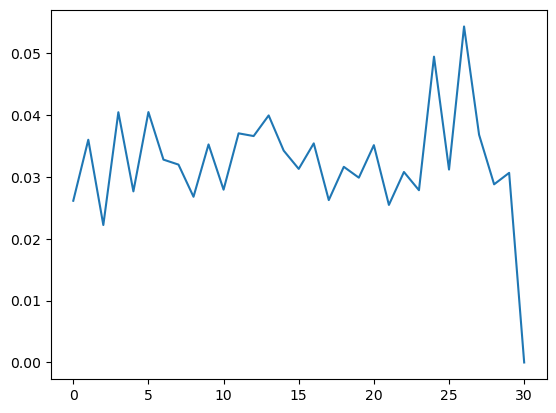

In [107]:
plt.plot(features[3])

f1 mean:  0.76463515675428
acc mean:  0.6387969401947149


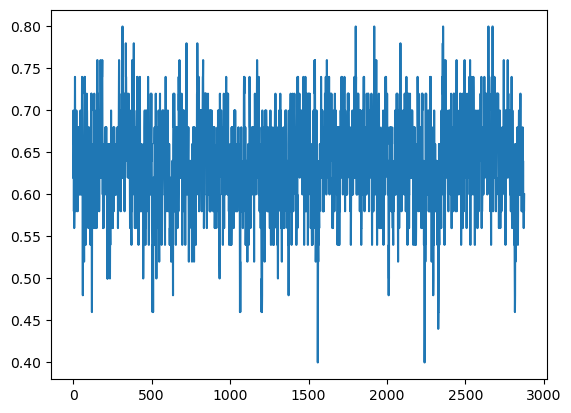

In [98]:
print('f1 mean: ', np.mean(timepoint_f1))
print('acc mean: ', np.mean(timepoint_accuracy))
plt.plot(timepoint_accuracy)
# plt.plot(unique_pred_0)

real data mean acc = 0.64

shuffled data mean acc = 0.58


# RESULTS

In [ ]:
X_training = X[:,:,1500]
print(train_3(X_training, y, verbose=True))

In [ ]:
from sklearn.svm import SVC
# from pyrcn.echo_state_network import ESNClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
# from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# scaler = StandardScaler()

clf = CatBoostClassifier(task_type = 'GPU')
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set:", accuracy)



catboost and RF both on more data with stacked are perfoming the same

next im gonna add labels for the subjects


In [ ]:
display(all_rawdata[0]['metadata'].columns)

In [ ]:
print(multivariate)

# multivariate test?

https://pypi.org/project/pyts/

In [ ]:
from pyts.classification import BOSSVS
from pyts.multivariate.classification import MultivariateClassifier

from pyts.datasets import load_basic_motions

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# X_train, X_test, y_train, y_test = load_basic_motions(return_X_y=True)

print(X_train.shape, y_train.shape)

# scaler = StandardScaler()

clf = CatBoostClassifier(task_type = 'GPU')
clf = RandomForestClassifier()
clf = MultivariateClassifier(BOSSVS())
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set:", accuracy)

